In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
import pickle
import requests
import joblib
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay


In [2]:
df = pd.read_csv("all_data.csv")
classes = ['normal', 'tcp-syn', 'udp-flood', 'icmp-echo', 'httpFlood']
df = df[df['class'].isin(classes)]

In [3]:
df.shape

(3538, 35)

In [4]:
df['class'].value_counts()

class
tcp-syn      960
udp-flood    773
icmp-echo    632
normal       600
httpFlood    573
Name: count, dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3538 entries, 0 to 3537
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ifInOctets11         3538 non-null   int64 
 1   ifOutOctets11        3538 non-null   int64 
 2   ifoutDiscards11      3538 non-null   int64 
 3   ifInUcastPkts11      3538 non-null   int64 
 4   ifInNUcastPkts11     3538 non-null   int64 
 5   ifInDiscards11       3538 non-null   int64 
 6   ifOutUcastPkts11     3538 non-null   int64 
 7   ifOutNUcastPkts11    3538 non-null   int64 
 8   tcpOutRsts           3538 non-null   int64 
 9   tcpInSegs            3538 non-null   int64 
 10  tcpOutSegs           3538 non-null   int64 
 11  tcpPassiveOpens      3538 non-null   int64 
 12  tcpRetransSegs       3538 non-null   int64 
 13  tcpCurrEstab         3538 non-null   int64 
 14  tcpEstabResets       3538 non-null   int64 
 15  tcp?ActiveOpens      3538 non-null   int64 
 16  udpInDatagr

In [6]:
# Split the dataset in train and test using stratify
train_data, test_data = train_test_split(df, test_size=0.3, stratify=df['class'], random_state=42)

In [7]:
train_data['class'].value_counts()

class
tcp-syn      672
udp-flood    541
icmp-echo    442
normal       420
httpFlood    401
Name: count, dtype: int64

# Data Analysis (Describe)

In [8]:
interface_columns = ['ifInOctets11', 'ifOutOctets11', 'ifoutDiscards11', 'ifInUcastPkts11', 'ifInNUcastPkts11', 'ifInDiscards11',
                     'ifOutUcastPkts11', 'ifOutNUcastPkts11']

tcp_columns = ['tcpOutRsts', 'tcpInSegs', 'tcpOutSegs', 'tcpPassiveOpens', 'tcpRetransSegs', 'tcpCurrEstab', 
               'tcpEstabResets', 'tcp?ActiveOpens'] 

udp_columns = ['udpInDatagrams', 'udpOutDatagrams', 'udpInErrors', 'udpNoPorts']

ip_columns = ['ipInReceives', 'ipInDelivers', 'ipOutRequests', 'ipOutDiscards', 'ipInDiscards', 'ipForwDatagrams', 
              'ipOutNoRoutes', 'ipInAddrErrors']

icmp_columns = ['icmpInMsgs', 'icmpInDestUnreachs', 'icmpOutMsgs', 'icmpOutDestUnreachs', 'icmpInEchos', 'icmpOutEchoReps']

normal_df = train_data[train_data['class'] == 'normal']
tcp_df = train_data[train_data['class'] == 'tcp-syn']
udp_df = train_data[train_data['class'] == 'udp-flood']
ip_df = train_data[train_data['class'] == 'httpFlood']
icmp_df = train_data[train_data['class'] == 'icmp-echo']


In [9]:
normal_df[tcp_columns].describe()

,tcpOutRsts,tcpInSegs,tcpOutSegs,tcpPassiveOpens,tcpRetransSegs,tcpCurrEstab,tcpEstabResets,tcp?ActiveOpens
count,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000
mean,1.526190,877.840476,698.226190,63.238095,6.988095,0.038095,4.828571,4.578571
std,0.499909,122.115348,100.741091,8.861462,6.670374,0.363589,0.377333,1.499727
min,1.000000,682.000000,537.000000,49.000000,0.000000,0.000000,4.000000,3.000000
25%,1.000000,790.000000,621.000000,57.000000,1.000000,0.000000,5.000000,3.000000
50%,2.000000,864.000000,684.000000,62.000000,1.000000,0.000000,5.000000,6.000000
75%,2.000000,973.000000,780.000000,70.000000,14.000000,0.000000,5.000000,6.000000
max,2.000000,1135.000000,906.000000,82.000000,14.000000,4.000000,5.000000,6.000000


In [10]:
tcp_df[tcp_columns].describe()

,tcpOutRsts,tcpInSegs,tcpOutSegs,tcpPassiveOpens,tcpRetransSegs,tcpCurrEstab,tcpEstabResets,tcp?ActiveOpens
count,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000
mean,3.127976,580.177083,479.340774,40.974702,4.092262,0.041667,6.178571,7.010417
std,1.166468,461.901238,357.121642,34.178905,7.423156,0.285865,1.229646,2.128834
min,1.000000,116.000000,115.000000,7.000000,0.000000,0.000000,4.000000,3.000000
25%,2.000000,195.000000,189.000000,12.000000,0.000000,0.000000,6.000000,6.000000
50%,4.000000,279.000000,241.000000,19.000000,1.000000,0.000000,6.000000,7.000000
75%,4.000000,1134.000000,910.000000,82.000000,4.000000,0.000000,8.000000,10.000000
max,4.000000,1305.000000,1039.000000,95.000000,24.000000,2.000000,8.000000,10.000000


In [11]:
normal_df[udp_columns].describe()

,udpInDatagrams,udpOutDatagrams,udpInErrors,udpNoPorts
count,420.000000,420.000000,420.000000,420.000000
mean,195146.559524,144327.290476,1.526190,28.840476
std,89395.491702,79922.161899,0.499909,6.498818
min,65473.000000,32868.000000,1.000000,22.000000
25%,113730.250000,69994.000000,1.000000,22.000000
50%,157840.500000,106080.000000,2.000000,35.000000
75%,281107.750000,222385.000000,2.000000,35.000000
max,330737.000000,263926.000000,2.000000,35.000000


In [12]:
udp_df[udp_columns].describe()

,udpInDatagrams,udpOutDatagrams,udpInErrors,udpNoPorts
count,541.000000,541.000000,541.000000,541.000000
mean,268970.802218,199532.909427,0.824399,27.181146
std,112149.070954,93466.873299,0.985373,8.006045
min,67712.000000,35496.000000,0.000000,16.000000
25%,130176.000000,91309.000000,0.000000,16.000000
50%,294961.000000,210876.000000,0.000000,28.000000
75%,363247.000000,285663.000000,2.000000,35.000000
max,418049.000000,334837.000000,2.000000,35.000000


In [13]:
normal_df[ip_columns].describe()

,ipInReceives,ipInDelivers,ipOutRequests,ipOutDiscards,ipInDiscards,ipForwDatagrams,ipOutNoRoutes,ipInAddrErrors
count,4.200000e+02,420.000000,420.000000,420.000000,420.000000,4.200000e+02,420.0,420.000000
mean,4.567160e+07,199077.380952,145109.214286,372.730952,30.366667,4.561733e+07,7.0,3.157143
std,2.345747e+07,90034.685285,79861.439934,186.466084,6.998727,2.344724e+07,0.0,2.999454
min,1.001080e+07,68234.000000,33566.000000,196.000000,23.000000,9.976933e+06,7.0,0.000000
25%,2.523943e+07,117136.000000,70869.000000,196.000000,23.000000,2.519272e+07,7.0,0.000000
50%,3.614004e+07,161850.500000,107087.000000,196.000000,37.000000,3.608505e+07,7.0,6.000000
75%,7.049199e+07,285595.750000,223078.000000,569.000000,37.000000,7.042912e+07,7.0,6.000000
max,7.558961e+07,335849.000000,264707.000000,569.000000,37.000000,7.551819e+07,7.0,6.000000


In [14]:
ip_df[ip_columns].describe()

,ipInReceives,ipInDelivers,ipOutRequests,ipOutDiscards,ipInDiscards,ipForwDatagrams,ipOutNoRoutes,ipInAddrErrors
count,4.010000e+02,401.000000,401.000000,401.000000,401.000000,4.010000e+02,401.000000,401.000000
mean,6.685043e+07,124366.710723,89677.251870,58.132170,24.201995,6.681748e+07,2.503741,51.234414
std,5.374738e+07,79551.701811,61183.378528,59.802508,7.514759,5.373326e+07,2.619277,9.552744
min,9.928590e+05,8811.000000,1398.000000,1.000000,16.000000,9.874700e+05,0.000000,42.000000
25%,3.703209e+07,55380.000000,38390.000000,6.000000,16.000000,3.701727e+07,0.000000,42.000000
50%,5.999039e+07,103033.000000,76108.000000,7.000000,30.000000,5.994377e+07,0.000000,42.000000
75%,8.309188e+07,184768.000000,132909.000000,125.000000,30.000000,8.304130e+07,5.000000,61.000000
max,2.899847e+08,338078.000000,265546.000000,127.000000,39.000000,2.899184e+08,7.000000,62.000000


In [15]:
normal_df[icmp_columns].describe()

,icmpInMsgs,icmpInDestUnreachs,icmpOutMsgs,icmpOutDestUnreachs,icmpInEchos,icmpOutEchoReps
count,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000
mean,59.640476,32.414286,49.173810,21.947619,27.226190,27.226190
std,6.708153,3.570602,3.437235,0.999818,3.339041,3.339041
min,47.000000,26.000000,41.000000,21.000000,20.000000,20.000000
25%,55.000000,29.000000,47.000000,21.000000,25.000000,25.000000
50%,59.000000,32.000000,49.000000,21.000000,27.000000,27.000000
75%,65.000000,35.000000,52.000000,23.000000,30.000000,30.000000
max,72.000000,38.000000,55.000000,23.000000,34.000000,34.000000


In [16]:
icmp_df[icmp_columns].describe()

,icmpInMsgs,icmpInDestUnreachs,icmpOutMsgs,icmpOutDestUnreachs,icmpInEchos,icmpOutEchoReps
count,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000
mean,69.918552,39.694570,41.868778,11.644796,30.223982,30.223982
std,25.863722,13.261692,15.989253,9.104736,12.770149,12.770149
min,12.000000,11.000000,13.000000,3.000000,1.000000,1.000000
25%,72.000000,39.000000,36.000000,3.000000,33.000000,33.000000
50%,78.000000,43.000000,39.000000,12.000000,35.000000,35.000000
75%,84.000000,46.000000,58.000000,23.000000,37.000000,37.000000
max,99.000000,58.000000,64.000000,23.000000,41.000000,41.000000


# Data Analysis (Correlation)

In [17]:
normal_corr_matrix = normal_df[tcp_columns].corr()
tcp_corr_matrix = tcp_df[tcp_columns].corr()

In [18]:
normal_corr_matrix

,tcpOutRsts,tcpInSegs,tcpOutSegs,tcpPassiveOpens,tcpRetransSegs,tcpCurrEstab,tcpEstabResets,tcp?ActiveOpens
tcpOutRsts,1.000000,0.673935,0.719383,0.658561,-0.998697,0.047020,-0.431625,1.000000
tcpInSegs,0.673935,1.000000,0.997990,0.999714,-0.645408,0.055073,0.197885,0.673935
tcpOutSegs,0.719383,0.997990,1.000000,0.996411,-0.692513,0.056191,0.147939,0.719383
tcpPassiveOpens,0.658561,0.999714,0.996411,1.000000,-0.629626,0.066808,0.212091,0.658561
tcpRetransSegs,-0.998697,-0.645408,-0.692513,-0.629626,1.000000,-0.047048,0.477093,-0.998697
tcpCurrEstab,0.047020,0.055073,0.056191,0.066808,-0.047048,1.000000,-0.021869,0.047020
tcpEstabResets,-0.431625,0.197885,0.147939,0.212091,0.477093,-0.021869,1.000000,-0.431625
tcp?ActiveOpens,1.000000,0.673935,0.719383,0.658561,-0.998697,0.047020,-0.431625,1.000000


In [19]:
tcp_corr_matrix

,tcpOutRsts,tcpInSegs,tcpOutSegs,tcpPassiveOpens,tcpRetransSegs,tcpCurrEstab,tcpEstabResets,tcp?ActiveOpens
tcpOutRsts,1.000000,-0.976755,-0.976242,-0.976114,-0.785861,-0.114341,0.653174,0.809071
tcpInSegs,-0.976755,1.000000,0.999885,0.999952,0.663922,0.104685,-0.672022,-0.776675
tcpOutSegs,-0.976242,0.999885,1.000000,0.999714,0.659628,0.104326,-0.663429,-0.767435
tcpPassiveOpens,-0.976114,0.999952,0.999714,1.000000,0.663220,0.107795,-0.677321,-0.780964
tcpRetransSegs,-0.785861,0.663922,0.659628,0.663220,1.000000,0.109150,-0.445905,-0.794603
tcpCurrEstab,-0.114341,0.104685,0.104326,0.107795,0.109150,1.000000,-0.097513,-0.123160
tcpEstabResets,0.653174,-0.672022,-0.663429,-0.677321,-0.445905,-0.097513,1.000000,0.848712
tcp?ActiveOpens,0.809071,-0.776675,-0.767435,-0.780964,-0.794603,-0.123160,0.848712,1.000000


In [20]:
normal_corr_matrix = normal_df[udp_columns].corr()
udp_corr_matrix = udp_df[udp_columns].corr()

In [21]:
normal_corr_matrix

,udpInDatagrams,udpOutDatagrams,udpInErrors,udpNoPorts
udpInDatagrams,1.000000,0.999564,-0.953760,-0.953760
udpOutDatagrams,0.999564,1.000000,-0.960745,-0.960745
udpInErrors,-0.953760,-0.960745,1.000000,1.000000
udpNoPorts,-0.953760,-0.960745,1.000000,1.000000


In [22]:
udp_corr_matrix

,udpInDatagrams,udpOutDatagrams,udpInErrors,udpNoPorts
udpInDatagrams,1.000000,0.995635,0.181519,-0.403522
udpOutDatagrams,0.995635,1.000000,0.089601,-0.485774
udpInErrors,0.181519,0.089601,1.000000,0.818589
udpNoPorts,-0.403522,-0.485774,0.818589,1.000000


In [23]:
normal_corr_matrix = normal_df[ip_columns].corr()
ip_corr_matrix = ip_df[ip_columns].corr()

In [24]:
normal_corr_matrix

,ipInReceives,ipInDelivers,ipOutRequests,ipOutDiscards,ipInDiscards,ipForwDatagrams,ipOutNoRoutes,ipInAddrErrors
ipInReceives,1.000000,0.997081,0.996551,0.959380,-0.959380,1.000000,NaN,-0.959380
ipInDelivers,0.997081,1.000000,0.999548,0.953188,-0.953188,0.997079,NaN,-0.953188
ipOutRequests,0.996551,0.999548,1.000000,0.960432,-0.960432,0.996552,NaN,-0.960432
ipOutDiscards,0.959380,0.953188,0.960432,1.000000,-1.000000,0.959410,NaN,-1.000000
ipInDiscards,-0.959380,-0.953188,-0.960432,-1.000000,1.000000,-0.959410,NaN,1.000000
ipForwDatagrams,1.000000,0.997079,0.996552,0.959410,-0.959410,1.000000,NaN,-0.959410
ipOutNoRoutes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ipInAddrErrors,-0.959380,-0.953188,-0.960432,-1.000000,1.000000,-0.959410,NaN,1.000000


In [25]:
ip_corr_matrix

,ipInReceives,ipInDelivers,ipOutRequests,ipOutDiscards,ipInDiscards,ipForwDatagrams,ipOutNoRoutes,ipInAddrErrors
ipInReceives,1.000000,0.884333,0.909598,0.242443,-0.005227,1.000000,0.675287,0.584908
ipInDelivers,0.884333,1.000000,0.998145,0.665870,-0.471144,0.884225,0.920561,0.881591
ipOutRequests,0.909598,0.998145,1.000000,0.621015,-0.419670,0.909503,0.898279,0.852978
ipOutDiscards,0.242443,0.665870,0.621015,1.000000,-0.969188,0.242220,0.851371,0.912172
ipInDiscards,-0.005227,-0.471144,-0.419670,-0.969188,1.000000,-0.004998,-0.698285,-0.785383
ipForwDatagrams,1.000000,0.884225,0.909503,0.242220,-0.004998,1.000000,0.675126,0.584726
ipOutNoRoutes,0.675287,0.920561,0.898279,0.851371,-0.698285,0.675126,1.000000,0.991521
ipInAddrErrors,0.584908,0.881591,0.852978,0.912172,-0.785383,0.584726,0.991521,1.000000


In [26]:
normal_corr_matrix = normal_df[icmp_columns].corr()
icmp_corr_matrix = icmp_df[icmp_columns].corr()

In [27]:
normal_corr_matrix

,icmpInMsgs,icmpInDestUnreachs,icmpOutMsgs,icmpOutDestUnreachs,icmpInEchos,icmpOutEchoReps
icmpInMsgs,1.000000,0.972759,0.876013,-0.223795,0.968787,0.968787
icmpInDestUnreachs,0.972759,1.000000,0.750966,-0.373634,0.884929,0.884929
icmpOutMsgs,0.876013,0.750966,1.000000,0.242249,0.956871,0.956871
icmpOutDestUnreachs,-0.223795,-0.373634,0.242249,1.000000,-0.050060,-0.050060
icmpInEchos,0.968787,0.884929,0.956871,-0.050060,1.000000,1.000000
icmpOutEchoReps,0.968787,0.884929,0.956871,-0.050060,1.000000,1.000000


In [28]:
icmp_corr_matrix

,icmpInMsgs,icmpInDestUnreachs,icmpOutMsgs,icmpOutDestUnreachs,icmpInEchos,icmpOutEchoReps
icmpInMsgs,1.000000,0.993782,0.872784,0.139562,0.993292,0.993292
icmpInDestUnreachs,0.993782,1.000000,0.910253,0.232084,0.974241,0.974241
icmpOutMsgs,0.872784,0.910253,1.000000,0.602687,0.822383,0.822383
icmpOutDestUnreachs,0.139562,0.232084,0.602687,1.000000,0.041642,0.041642
icmpInEchos,0.993292,0.974241,0.822383,0.041642,1.000000,1.000000
icmpOutEchoReps,0.993292,0.974241,0.822383,0.041642,1.000000,1.000000


# Data Analysis (Mutual Information)

In [29]:
# Selecting the features
features = train_data.drop(columns=['class'])

# Calculating the mutual information between the features and the target
mutual_info = mutual_info_classif(features, train_data['class'])

# Creating a dataframe
mutual_info = pd.Series(mutual_info, index=features.columns, name='Mutual Information')
mutual_info.sort_values(ascending=False)


ipForwDatagrams        0.655846
ipInReceives           0.654562
udpNoPorts             0.629317
icmpInDestUnreachs     0.534346
ifOutNUcastPkts11      0.531302
icmpOutMsgs            0.524843
ifInUcastPkts11        0.524689
icmpInMsgs             0.511290
ifInNUcastPkts11       0.498903
tcpInSegs              0.484565
icmpInEchos            0.476404
icmpOutEchoReps        0.461223
tcpOutSegs             0.456643
tcpPassiveOpens        0.452770
ipOutNoRoutes          0.443739
ipInDiscards           0.437527
tcpOutRsts             0.435034
tcpEstabResets         0.407031
udpInDatagrams         0.384237
ipInAddrErrors         0.375227
ipInDelivers           0.374455
ipOutRequests          0.367627
udpOutDatagrams        0.360531
ifOutUcastPkts11       0.352954
udpInErrors            0.317786
ifOutOctets11          0.213341
ipOutDiscards          0.209589
tcpRetransSegs         0.203817
tcp?ActiveOpens        0.157339
icmpOutDestUnreachs    0.142962
ifInDiscards11         0.082688
ifoutDis

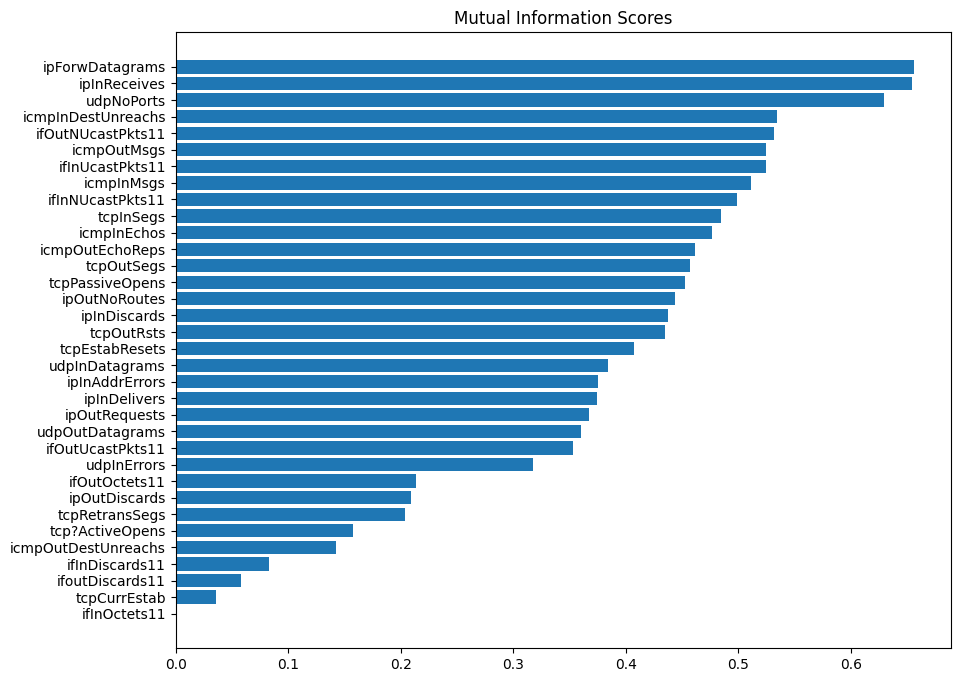

In [30]:
# Visualization of the results
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(10, 8))
plot_mi_scores(mutual_info)

# Baseline

## Baseline with SVM and class weight

Top 10 Features
Accuracy: 0.992467043314501
Classification Report:
               precision    recall  f1-score   support

   httpFlood       1.00      0.97      0.98       172
   icmp-echo       0.99      1.00      0.99       190
      normal       1.00      1.00      1.00       180
     tcp-syn       0.98      0.99      0.99       288
   udp-flood       1.00      1.00      1.00       232

    accuracy                           0.99      1062
   macro avg       0.99      0.99      0.99      1062
weighted avg       0.99      0.99      0.99      1062



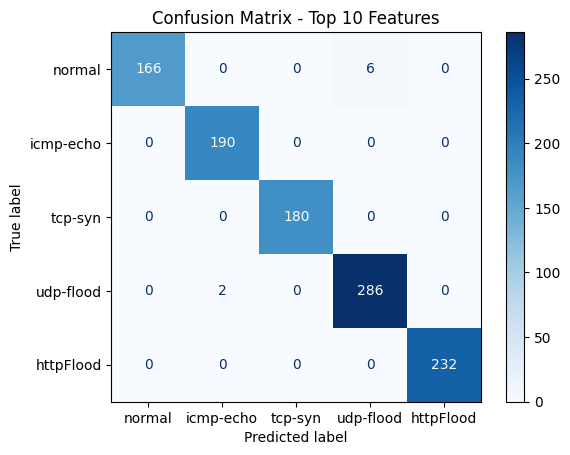


Top 15 Features
Accuracy: 0.992467043314501
Classification Report:
               precision    recall  f1-score   support

   httpFlood       1.00      0.97      0.98       172
   icmp-echo       0.99      1.00      0.99       190
      normal       1.00      1.00      1.00       180
     tcp-syn       0.98      0.99      0.99       288
   udp-flood       1.00      1.00      1.00       232

    accuracy                           0.99      1062
   macro avg       0.99      0.99      0.99      1062
weighted avg       0.99      0.99      0.99      1062



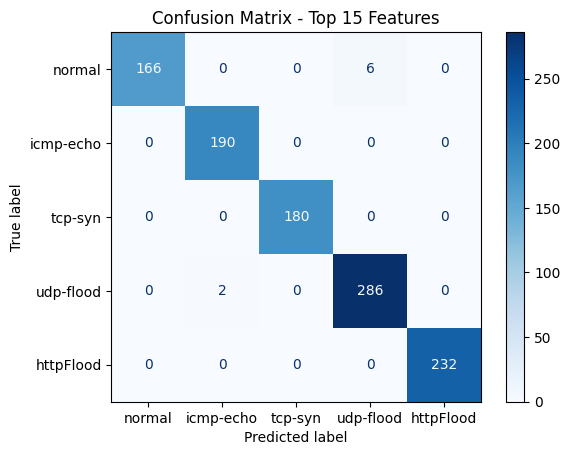

In [31]:
# Data preparation
X_train = train_data.drop(columns=['class'])
y_train = train_data['class']
X_test = test_data.drop(columns=['class'])
y_test = test_data['class']

# Mutual Information
mi = mutual_info_classif(X_train, y_train)
mi_series = pd.Series(mi, index=X_train.columns).sort_values(ascending=False)

# Selecting the 10 and 15 best features
top_10_features = mi_series.head(10).index.tolist()
top_15_features = mi_series.head(15).index.tolist()

# Function to evaluate the SVC model
def train_and_evaluate_svm_with_class_weights(features):
    X_train_selected = X_train[features]
    X_test_selected = X_test[features]
    
    # Data normalization
    scaler = StandardScaler()
    X_train_selected = scaler.fit_transform(X_train_selected)
    X_test_selected = scaler.transform(X_test_selected)
    
    # Model training
    svm = SVC(class_weight='balanced', decision_function_shape='ovo', random_state=42)
    svm.fit(X_train_selected, y_train)
    
    # Prediction and evaluation
    y_pred = svm.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    return accuracy, report, cm

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, title):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df['class'].unique())
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Training and evaluation for the 10 best features
accuracy_10, report_10, cm_10 = train_and_evaluate_svm_with_class_weights(top_10_features)
print("Top 10 Features")
print("Accuracy:", accuracy_10)
print("Classification Report:\n", report_10)
plot_confusion_matrix(cm_10, "Confusion Matrix - Top 10 Features")

# Training and evaluation for the 15 best features
accuracy_15, report_15, cm_15 = train_and_evaluate_svm_with_class_weights(top_15_features)
print("\nTop 15 Features")
print("Accuracy:", accuracy_15)
print("Classification Report:\n", report_15)
plot_confusion_matrix(cm_15, "Confusion Matrix - Top 15 Features")



## Baseline with SVM, class weight, and StratifiedKFold

SVM - Top 10 Features
              precision    recall  f1-score   support

   httpFlood       1.00      0.96      0.98       401
   icmp-echo       0.99      0.99      0.99       442
      normal       0.99      1.00      1.00       420
     tcp-syn       0.98      0.99      0.98       672
   udp-flood       1.00      1.00      1.00       541

    accuracy                           0.99      2476
   macro avg       0.99      0.99      0.99      2476
weighted avg       0.99      0.99      0.99      2476



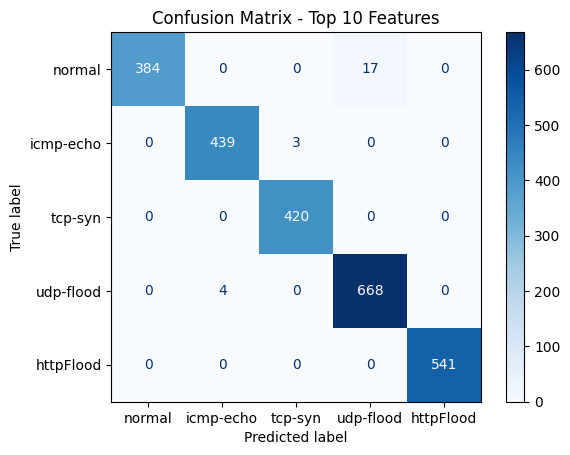


SVM - Top 15 Features
              precision    recall  f1-score   support

   httpFlood       1.00      0.96      0.98       401
   icmp-echo       0.99      0.99      0.99       442
      normal       0.99      1.00      1.00       420
     tcp-syn       0.98      0.99      0.98       672
   udp-flood       1.00      1.00      1.00       541

    accuracy                           0.99      2476
   macro avg       0.99      0.99      0.99      2476
weighted avg       0.99      0.99      0.99      2476



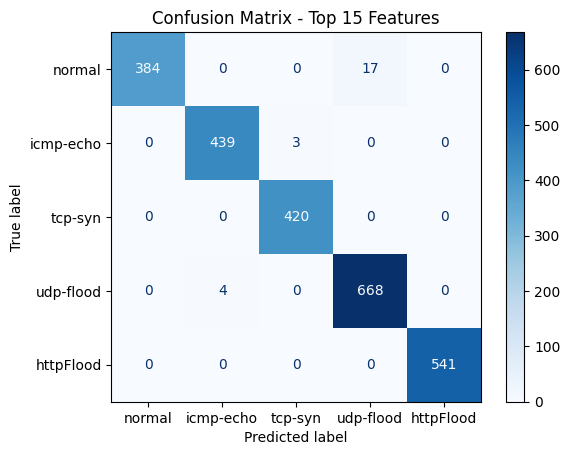


SVM - Top 10 Features - Accuracy: 0.9903069466882067
Metrics per class:
Class httpFlood: Precision: 1.0, Recall: 0.9576059850374065, F1-score: 0.978343949044586
Class icmp-echo: Precision: 0.9909706546275395, Recall: 0.9932126696832579, F1-score: 0.9920903954802259
Class normal: Precision: 0.9929078014184397, Recall: 1.0, F1-score: 0.9964412811387899
Class tcp-syn: Precision: 0.9751824817518249, Recall: 0.9940476190476191, F1-score: 0.9845246868091379
Class udp-flood: Precision: 1.0, Recall: 1.0, F1-score: 1.0

SVM - Top 15 Features - Accuracy: 0.9903069466882067
Metrics per class:
Class httpFlood: Precision: 1.0, Recall: 0.9576059850374065, F1-score: 0.978343949044586
Class icmp-echo: Precision: 0.9909706546275395, Recall: 0.9932126696832579, F1-score: 0.9920903954802259
Class normal: Precision: 0.9929078014184397, Recall: 1.0, F1-score: 0.9964412811387899
Class tcp-syn: Precision: 0.9751824817518249, Recall: 0.9940476190476191, F1-score: 0.9845246868091379
Class udp-flood: Precision

In [32]:
# Data preparation
X_train = train_data.drop(columns=['class'])
y_train = train_data['class']
X_test = test_data.drop(columns=['class'])
y_test = test_data['class']

# Mutual Information 
mi = mutual_info_classif(X_train, y_train)
mi_series = pd.Series(mi, index=X_train.columns).sort_values(ascending=False)

# Selecting the 10 and 15 best features
top_10_features = mi_series.head(10).index.tolist()
top_15_features = mi_series.head(15).index.tolist()

# Function to train and evaluate the SVM model with cross validation
def train_and_evaluate_svm_cv(features):
    X_train_selected = X_train[features]
    
    # Data normalization
    scaler = StandardScaler()
    X_train_selected = scaler.fit_transform(X_train_selected)
    
    # Training the SVC modelo with class weight
    svm = SVC(class_weight='balanced', probability=True, random_state=42)
    
    # Cross validation with stratified k fold
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    y_pred = cross_val_predict(svm, X_train_selected, y_train, cv=cv)
    
    # Classification report
    report = classification_report(y_train, y_pred, output_dict=True)
    
    # Confusion matrix
    cm = confusion_matrix(y_train, y_pred)
    
    return report, cm

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, title):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df['class'].unique())
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Training and evaluation for the 10 best features
report_svm_10, cm_10 = train_and_evaluate_svm_cv(top_10_features)
print("SVM - Top 10 Features")
print(classification_report(y_train, cross_val_predict(SVC(class_weight='balanced', decision_function_shape='ovo',
                                                           random_state=42), 
                                                 StandardScaler().fit_transform(X_train[top_10_features]), 
                                                 y_train, 
                                                 cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42))))
plot_confusion_matrix(cm_10, "Confusion Matrix - Top 10 Features")

# Training and evaluation for the 15 best features
report_svm_15, cm_15 = train_and_evaluate_svm_cv(top_15_features)
print("\nSVM - Top 15 Features")
print(classification_report(y_train, cross_val_predict(SVC(class_weight='balanced', random_state=42), 
                                                 StandardScaler().fit_transform(X_train[top_15_features]), 
                                                 y_train, 
                                                 cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42))))
plot_confusion_matrix(cm_15, "Confusion Matrix - Top 15 Features")

# Extracting the metrics
def extract_metrics(report):
    accuracy = report['accuracy']
    metrics_per_class = {label: {
        'precision': metrics['precision'],
        'recall': metrics['recall'],
        'f1-score': metrics['f1-score']
    } for label, metrics in report.items() if label not in ['accuracy', 'macro avg', 'weighted avg']}
    return accuracy, metrics_per_class

# Results of the 10 best features
accuracy_10, metrics_per_class_10 = extract_metrics(report_svm_10)

# Results of the 10 best features
accuracy_15, metrics_per_class_15 = extract_metrics(report_svm_15)

# Printing the results
print("\nSVM - Top 10 Features - Accuracy:", accuracy_10)
print("Metrics per class:")
for label, metrics in metrics_per_class_10.items():
    print(f"Class {label}: Precision: {metrics['precision']}, Recall: {metrics['recall']}, F1-score: {metrics['f1-score']}")

print("\nSVM - Top 15 Features - Accuracy:", accuracy_15)
print("Metrics per class:")
for label, metrics in metrics_per_class_15.items():
    print(f"Class {label}: Precision: {metrics['precision']}, Recall: {metrics['recall']}, F1-score: {metrics['f1-score']}")
